In [1]:
%matplotlib inline


# Extracting signals of a probabilistic atlas of functional regions

This example extracts the signal on regions defined via a probabilistic
atlas, to construct a functional connectome.

We use the `MSDL atlas
<https://team.inria.fr/parietal/18-2/spatial_patterns/spatial-patterns-in-resting-state/>`_
of functional regions in movie-watching.

The key to extract signals is to use the
:class:`nilearn.input_data.NiftiMapsMasker` that can transform nifti
objects to time series using a probabilistic atlas.

As the MSDL atlas comes with (x, y, z) MNI coordinates for the different
regions, we can visualize the matrix as a graph of interaction in a
brain. To avoid having too dense a graph, we represent only the 20% edges
with the highest values.


## Retrieve the atlas and the data



In [2]:
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

# Load the functional datasets
data = datasets.fetch_development_fmri(n_subjects=1)

print('First subject resting-state nifti image (4D) is located at: %s' %
      data.func[0])

First subject resting-state nifti image (4D) is located at: C:\Users\sz144/nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


C:\Users\sz144\AppData\Roaming\Python\Python38\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
C:\Users\sz144\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


## Extract the time series



In [3]:
from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(data.func[0],
                                   confounds=data.confounds)

[NiftiMapsMasker.fit_transform] loading regions from C:\Users\sz144\nilearn_data\msdl_atlas\MSDL_rois\msdl_rois.nii
Resampling maps


C:\Users\sz144\AppData\Roaming\Python\Python38\site-packages\nilearn\_utils\cache_mixin.py:303: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x000002186C519F10>, interpolation='continuous', target_shape=(50, 59, 50), target_affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]]))
_____________________________________________________resample_img - 5.2s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('C:\\Users\\sz144/nilearn_data\\development_fmri\\development_fmri\\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'maps_img': 'C:\\Users\\sz144/ni

C:\Users\sz144\AppData\Roaming\Python\Python38\site-packages\nilearn\input_data\nifti_maps_masker.py:339: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


`time_series` is now a 2D matrix, of shape (number of time points x
number of regions)



In [4]:
print(time_series.shape)

(168, 39)


## Build and display a correlation matrix



C:\Users\sz144\AppData\Roaming\Python\Python38\site-packages\nilearn\plotting\matrix_plotting.py:22: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ylabel_width = ax.yaxis.get_tightbbox(renderer).inverse_transformed(
C:\Users\sz144\AppData\Roaming\Python\Python38\site-packages\nilearn\plotting\matrix_plotting.py:30: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  xlabel_height = ax.xaxis.get_tightbbox(renderer).inverse_transformed(


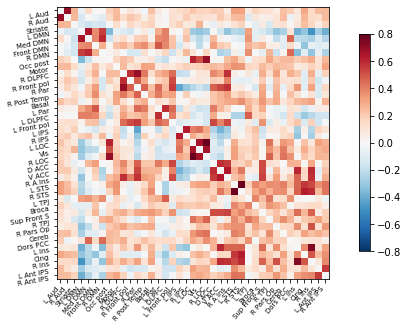

In [5]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=0.8, vmin=-0.8)

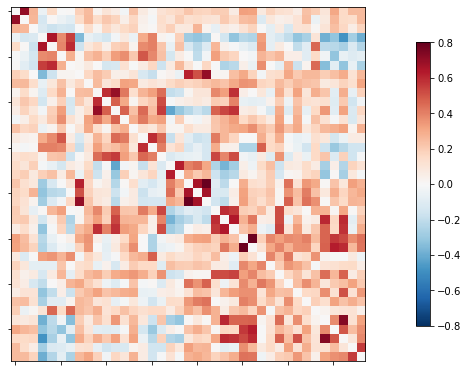

In [7]:
import matplotlib.pylab as plt
plotting.plot_matrix(correlation_matrix, colorbar=True,
                     vmax=0.8, vmin=-0.8)
plt.savefig('brain_network.pdf', format='pdf', bbox_inches='tight')

C:\Users\sz144\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


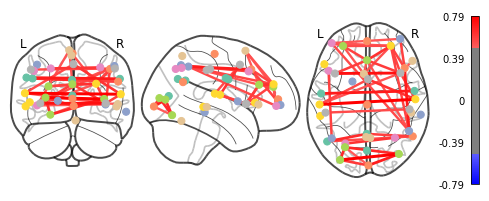

In [10]:
atlas_data = datasets.fetch_atlas_msdl()
# atlas_filename = atlas_data.maps
# coords = atlas.region_coords
coords = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas_data.maps)

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="95%", colorbar=True)

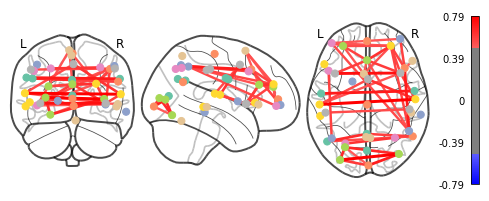

In [11]:
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="95%", colorbar=True)
plt.savefig('brain_network1.pdf', format='pdf', bbox_inches='tight')

## And now display the corresponding graph



In [ ]:
from nilearn import plotting
coords = atlas.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

## 3D visualization in a web browser
An alternative to :func:`nilearn.plotting.plot_connectome` is to use
:func:`nilearn.plotting.view_connectome` that gives more interactive
visualizations in a web browser. See `interactive-connectome-plotting`
for more details.



In [ ]:
view = plotting.view_connectome(correlation_matrix, coords, edge_threshold='80%')

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [ ]:
# uncomment this to open the plot in a web browser:
# view.open_in_browser()